# Regression

Methods we are using :

1. Naive Forecasting
2. Moving Average
3. Difference Moving Average with past 
4. Difference Moving Average with smoothed past

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go

In [4]:
keras = tf.keras
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00580/hungary_chickenpox.zip"

In [5]:
# download and unzip required file
import requests, zipfile, io
r = requests.get(URL)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content/chickenpox")

In [6]:
# read the files
train_df = pd.read_csv('/content/chickenpox/hungary_chickenpox.csv')
test_df = pd.read_csv('/content/chickenpox/hungary_county_edges.csv')

In [7]:
train_df.head()

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      522 non-null    object
 1   BUDAPEST  522 non-null    int64 
 2   BARANYA   522 non-null    int64 
 3   BACS      522 non-null    int64 
 4   BEKES     522 non-null    int64 
 5   BORSOD    522 non-null    int64 
 6   CSONGRAD  522 non-null    int64 
 7   FEJER     522 non-null    int64 
 8   GYOR      522 non-null    int64 
 9   HAJDU     522 non-null    int64 
 10  HEVES     522 non-null    int64 
 11  JASZ      522 non-null    int64 
 12  KOMAROM   522 non-null    int64 
 13  NOGRAD    522 non-null    int64 
 14  PEST      522 non-null    int64 
 15  SOMOGY    522 non-null    int64 
 16  SZABOLCS  522 non-null    int64 
 17  TOLNA     522 non-null    int64 
 18  VAS       522 non-null    int64 
 19  VESZPREM  522 non-null    int64 
 20  ZALA      522 non-null    int64 
dtypes: int64(20), ob

In [9]:
# To create a column which sum of the rest of columns for nation level 
train_df['TOTAL'] = train_df.iloc[:,1:].sum(axis=1)

In [10]:
train_df.shape

(522, 22)

# Visual extraction of data

In [11]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=5)
    plt.grid(True)


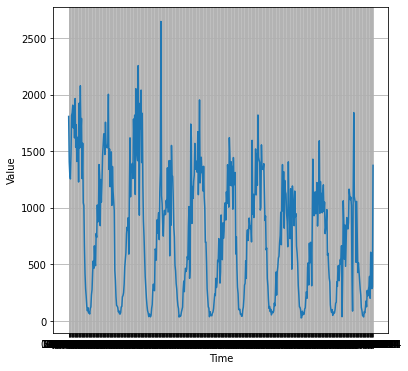

In [12]:
time = np.array(train_df['Date'])
series = train_df['TOTAL'] 
plt.figure(figsize=(6,6))
plot_series(time,series)
plt.show()

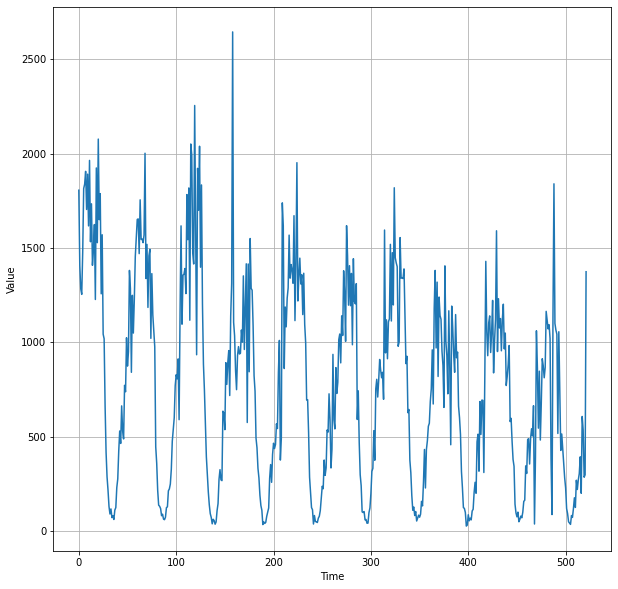

In [13]:
# discarded the date object with integers
# done to find where to split data 
time = np.arange(0,522) 
plt.figure(figsize=(10,10))
plot_series(time,series)
plt.show()

In [14]:
# Plotly helps to find out seasonality
fig = go.Figure(go.Scatter(
    x=time,
     y=series,
     name = "Total cases Data"))
fig.show()

In [15]:
# splitting series into training and validation split since data is less 
time_split = 400
time_train = time[:time_split]
x_train = series[:time_split]
time_val = time[time_split:]
x_val = series[time_split:]

# Naive Forecasting

In [16]:
naive_forecast = series[time_split-1:-1]

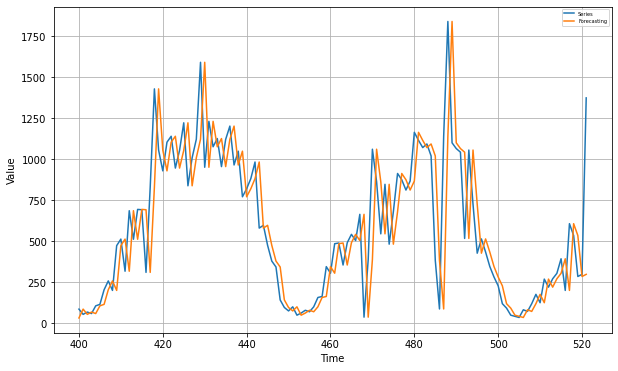

In [17]:
plt.figure(figsize=(10,6))
plot_series(time_val,x_val , label="Series")
plot_series(time_val,naive_forecast , label="Forecasting")

In [18]:
naive_forecast = np.array(naive_forecast)
x_val = np.array(x_val)

In [19]:
errors = naive_forecast - x_val
abs_errors = abs(errors)
mae = abs_errors.mean()
mae

181.04918032786884

This is our baseline for our further models

# Moving Average

In [20]:
def moving_average(series,window_size):
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size-1:-1]/window_size 

In [21]:
series = np.array(series)
moving_avg = moving_average(series,10)[time_split-10:]

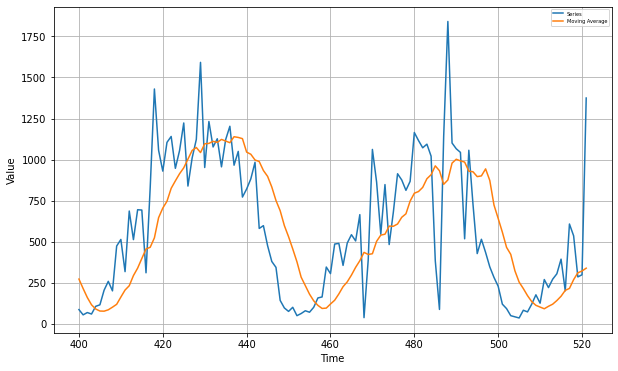

In [22]:
plt.figure(figsize=(10,6))
plot_series(time_val,x_val,label="Series")
plot_series(time_val,moving_avg,label="Moving Average")

In [23]:
print(keras.metrics.mean_absolute_error(x_val, moving_avg).numpy())
print("This is very high as compared to our previous naive model , since it didn't capture any seasonality")

251.91393442622947
This is very high as compared to our previous naive model , since it didn't capture any seasonality


# Difference moving average 

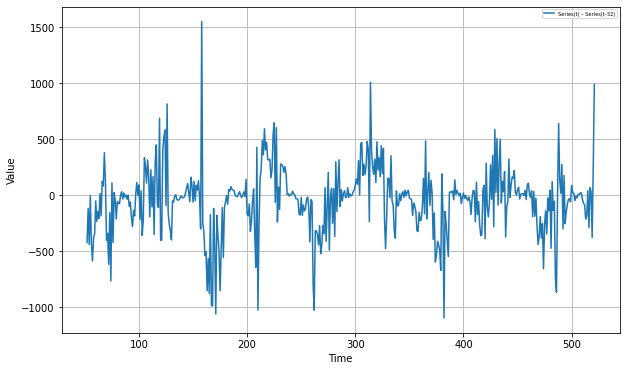

In [24]:
# 438 to get a whole cycle , seasonality period = 52 / 53
seasonality_period = 52
diff_series = (series[seasonality_period:] - series[:-seasonality_period])
diff_time = time[seasonality_period:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label=f"Series(t) – Series(t–{seasonality_period})")
plt.show()

this eliminates seasonality and trend

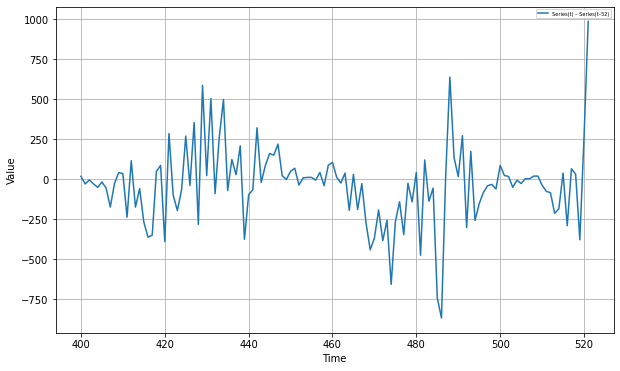

In [25]:
plt.figure(figsize=(10,6))
plot_series(time_val,diff_series[time_split-seasonality_period:],label = f"Series(t) – Series(t–{seasonality_period})")
plt.show()

We now make use of moving average


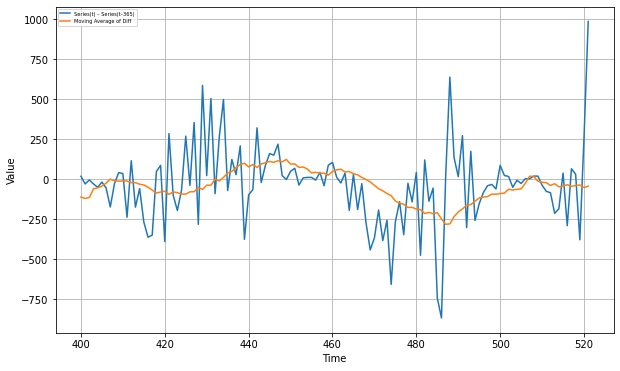

In [26]:
diff_moving_avg = moving_average(diff_series,20)[time_split-seasonality_period-20:]

plt.figure(figsize=(10, 6))
plot_series(time_val, diff_series[time_split - seasonality_period:], label="Series(t) – Series(t–365)")
plot_series(time_val, diff_moving_avg, label="Moving Average of Diff")
plt.show()

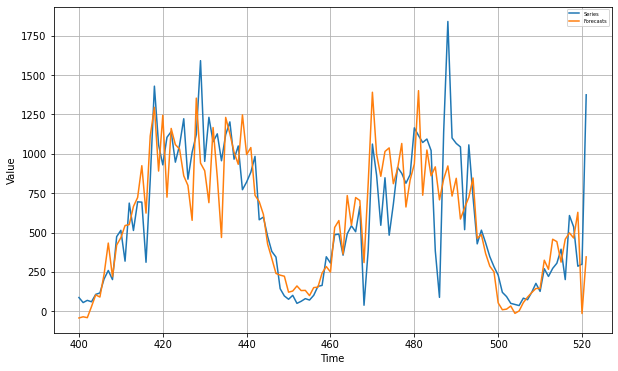

In [27]:
diff_moving_avg_plus_past = diff_moving_avg + series[time_split-seasonality_period:-seasonality_period]

plt.figure(figsize=(10, 6))
plot_series(time_val, x_val, label="Series")
plot_series(time_val, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [28]:
keras.metrics.mean_absolute_error(x_val,diff_moving_avg_plus_past).numpy()

170.4610655737705

This is a lot better from our naive model

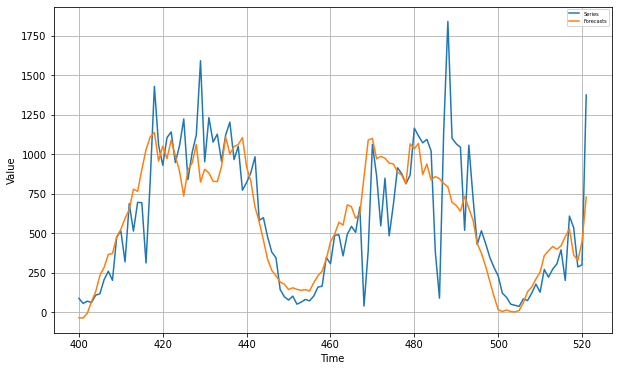

In [29]:
# better than above model when window_size is 3
diff_moving_avg_plus_smooth_past = moving_average(series[time_split - seasonality_period:-seasonality_period+3],3) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_val, x_val, label="Series")
plot_series(time_val, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [30]:
keras.metrics.mean_absolute_error(x_val,diff_moving_avg_plus_smooth_past).numpy()

172.6400273224044

This is almost similar to our model above.

All of our models are basic models where we have to hardcode most of the things into functions. Currently the best method to provide least mean absolute error is <b>difference moving average</b> .

Minimum Mean Absolute Error observed : 170.4610655737705


<hr>